In [1]:
%cd ..

/home/ameral/master/param2weld


In [ ]:
import param2weld.utils.plot_config # latex config
myblue = "#377eb8"
mygreen = "#4daf4a"
myred = "#e41a1c"
myorange = "#ff7f00"



In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle, Circle

plt.rcdefaults()

# Colors
White = 1.
Light = 0.7
Medium = 0.5
Dark = 0.3
Darker = 0.15
Black = 0.

NumDots = 4
NumConvMax = 8

def add_layer(patches, colors, size=(24, 24), num=5, top_left=[0, 0], loc_diff=[3, -3]):
    top_left = np.array(top_left)
    loc_diff = np.array(loc_diff)
    loc_start = top_left - np.array([0, size[0]])
    for ind in range(num):
        patches.append(Rectangle(loc_start + ind * loc_diff, size[1], size[0]))
        colors.append(Medium if ind % 2 else Light)

def add_layer_with_omission(patches, colors, size=(24, 24), num=5, num_max=8, num_dots=4, top_left=[0, 0], loc_diff=[3, -3]):
    top_left = np.array(top_left)
    loc_diff = np.array(loc_diff)
    loc_start = top_left - np.array([0, size[0]])
    this_num = min(num, num_max)
    start_omit = (this_num - num_dots) // 2 - 1
    end_omit = this_num - ((this_num - num_dots) // 2)

    for ind in range(this_num):
        omit = (num > num_max) and (start_omit < ind < end_omit)
        if omit:
            patches.append(Circle(loc_start + ind * loc_diff + np.array(size) / 2, 0.5))
            colors.append(Black)
        else:
            patches.append(Rectangle(loc_start + ind * loc_diff, size[1], size[0]))
            colors.append(Medium if ind % 2 else Light)

def label(xy, text, xy_off=[0, 4], font_size=16):
    plt.text(xy[0] + xy_off[0], xy[1] + xy_off[1], text, family='sans-serif', size=font_size)

patches = []
colors = []
fig, ax = plt.subplots()

size_list = [
    (1, 3), (1, 16), (8, 8), (16, 16), (32, 32), # (32, 32),
     (32, 32), (32, 32)
]

num_list = [
    1, 1, 32, 64, 32,
     # 32,
    32, 1
]

text_list = [
    'Input\n3 Params',
    'Dense\n',
    'Reshape\n8×8×32',
    'Up+Conv\n 16×16(x64)',
    'Up+Conv\n 32×32(x32)',
    'Residual Block\n',
    'Output\n32×32×1'
]

x_gap = 50
loc_diff_list = [[3, -3]] * len(size_list)
top_left_list = np.c_[np.cumsum([0] + [x_gap] * (len(size_list) - 1)), np.zeros(len(size_list))]
# add some space before last layer
top_left_list[-1][0] += 10

for ind in range(len(size_list)-1, -1, -1):
    add_layer_with_omission(
        patches, colors, size=size_list[ind],
        num=num_list[ind], num_max=NumConvMax, num_dots=NumDots,
        top_left=top_left_list[ind], loc_diff=loc_diff_list[ind]
    )
    
    label(top_left_list[ind], text_list[ind], font_size=16)

for patch, color in zip(patches, colors):
    patch.set_color(color * np.ones(3))
    if isinstance(patch, Line2D):
        ax.add_line(patch)
    else:
        patch.set_edgecolor(Black * np.ones(3))
        ax.add_patch(patch)

plt.axis('equal')
plt.axis('off')
fig.set_size_inches(12, 2)
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

# create directory if it does not exist
if not os.path.exists("figures"):
    os.makedirs("figures")
plt.savefig("./figures/network_architecture.pdf", bbox_inches='tight', dpi=300)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from param2weld.predict.ensemble import load_ensemble_models, predict_ensemble
from param2weld.data.scaler import load_scaler
from param2weld.data.loader import load_data

# Configurations
resolution = 32
start_frac = 0.5
end_frac = 0.8

# Paths
mean_model_dir = Path("models/mean/mae80_ssim20")
median_model_dir = Path("models/median/mae80_ssim20")
holdout_dir = Path("holdout-data")
out_dir = Path("figures/ensemble_preds")
out_dir.mkdir(parents=True, exist_ok=True)

# Load ensemble models and scalers
scalers = [load_scaler(mean_model_dir / f"scaler_fold_{i}.pkl") for i in range(10)]
mean_ensemble = load_ensemble_models(mean_model_dir)
median_ensemble = load_ensemble_models(median_model_dir)

# Average input scaling using all scalers
def average_scaler_transform(X, scalers):
    return np.mean([s.transform(X) for s in scalers], axis=0)

# Process each simulation folder
for sim_folder in sorted(holdout_dir.iterdir()):
    if not sim_folder.is_dir():
        continue

    # Extract parameters from folder name
    try:
        _, v, p, s = sim_folder.name.split("_")
        params = [float(v), float(p), float(s)]
    except ValueError:
        print(f"Skipping {sim_folder.name} — name format invalid.")
        continue

    # Load GT image using mean strategy
    _, y_mean, _ = load_data(
        folders=[sim_folder],
        resolution=resolution,
        mid_mode="mean",
        start_frac=start_frac,
        end_frac=end_frac,
    )

    # Load GT image using median strategy
    _, y_median, _ = load_data(
        folders=[sim_folder],
        resolution=resolution,
        mid_mode="median",
        start_frac=start_frac,
        end_frac=end_frac,
    )

    if y_mean.size == 0 or y_median.size == 0:
        print(f"Skipping {sim_folder.name} — no valid images.")
        continue

    mean_gt = y_mean[0].reshape(resolution, resolution)
    median_gt = y_median[0].reshape(resolution, resolution)

    # Predict using ensemble
    input_scaled = average_scaler_transform([params], scalers)
    mean_pred = predict_ensemble(mean_ensemble, input_scaled)[0, :, :, 0]
    median_pred = predict_ensemble(median_ensemble, input_scaled)[0, :, :, 0]

    # Save mean row (GT vs pred)
    fig, axs = plt.subplots(1, 2, figsize=(4.2, 2.1))
    axs[0].imshow(mean_gt, cmap="gray", vmin=0, vmax=1)
    axs[1].imshow(mean_pred, cmap="gray", vmin=0, vmax=1)
    for ax in axs:
        ax.axis("off")
    plt.subplots_adjust(wspace=0.05, hspace=0)
    fname = out_dir / f"{sim_folder.name}_mean.png"
    fig.savefig(fname, bbox_inches="tight", pad_inches=0, dpi=100)
    plt.show()

    plt.close(fig)

    # Save median row (GT vs pred)
    fig, axs = plt.subplots(1, 2, figsize=(4.2, 2.1))
    axs[0].imshow(median_gt, cmap="gray", vmin=0, vmax=1)
    axs[1].imshow(median_pred, cmap="gray", vmin=0, vmax=1)
    for ax in axs:
        ax.axis("off")
    plt.subplots_adjust(wspace=0.05, hspace=0)
    fname = out_dir / f"{sim_folder.name}_median.png"
    fig.savefig(fname, bbox_inches="tight", pad_inches=0, dpi=100)
    plt.show()
    plt.close(fig)

    print(f"Saved {sim_folder.name}_mean.png and _median.png")


### Exploring the Parameter Space

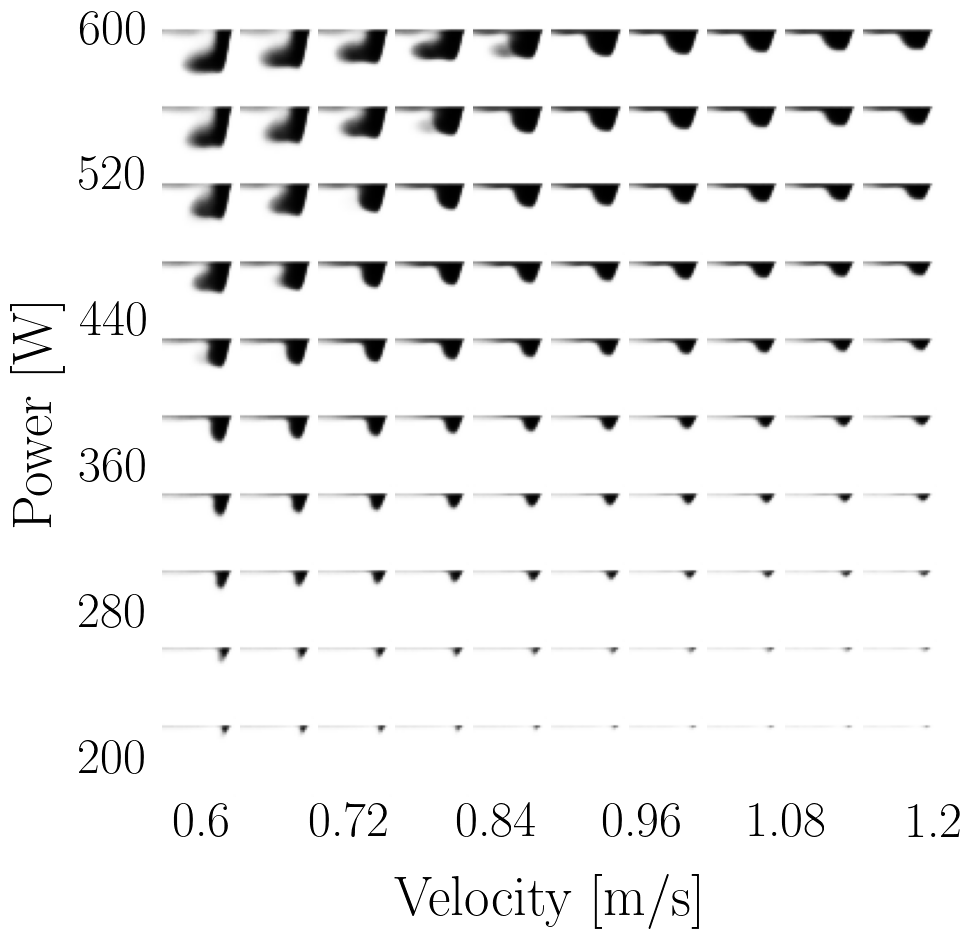

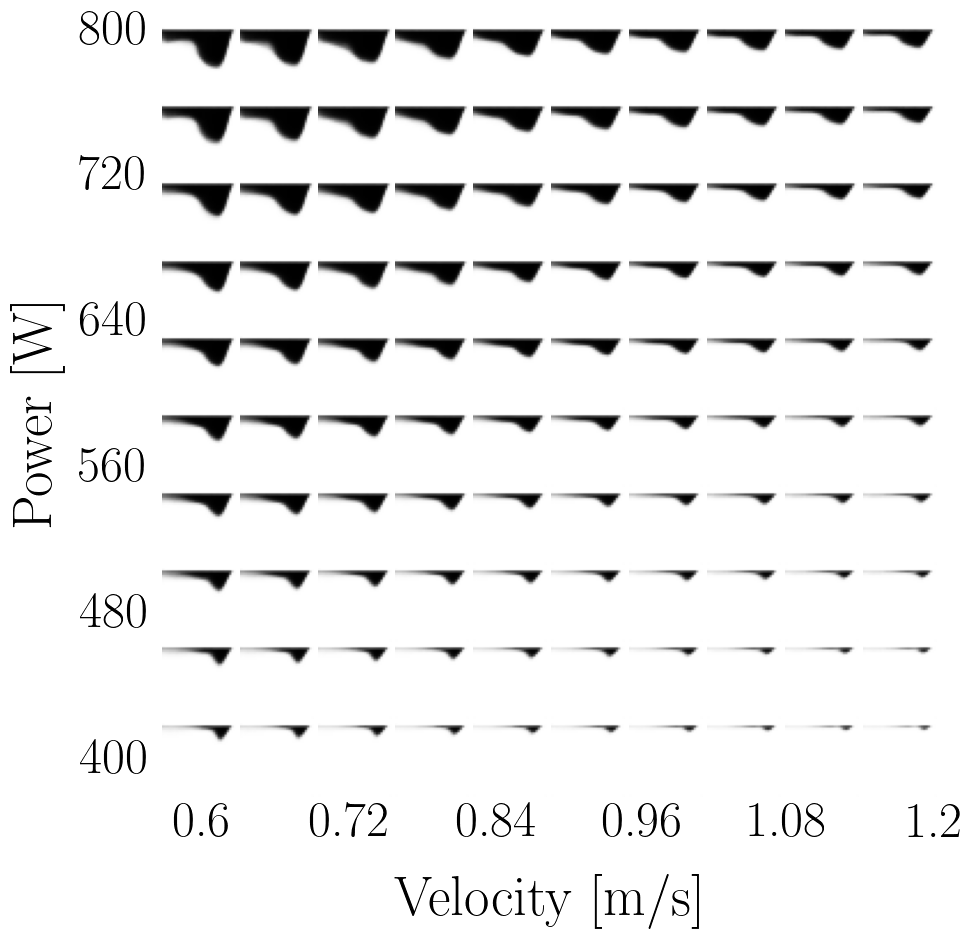

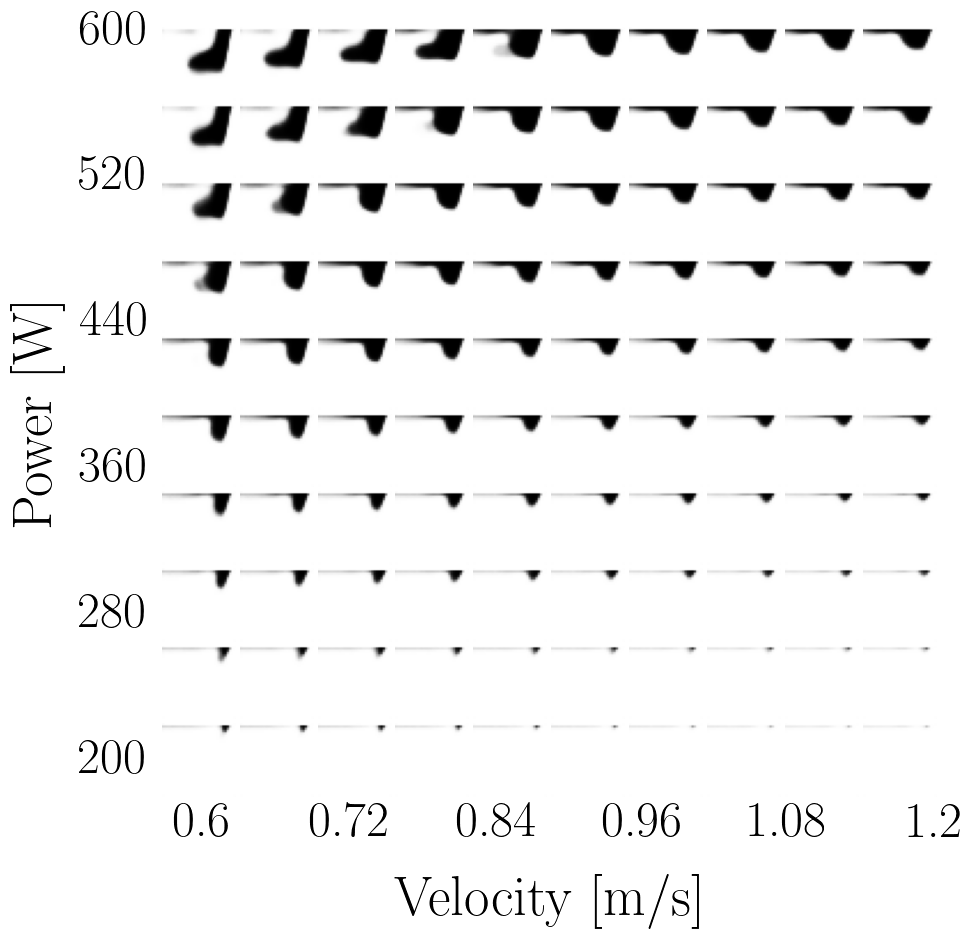

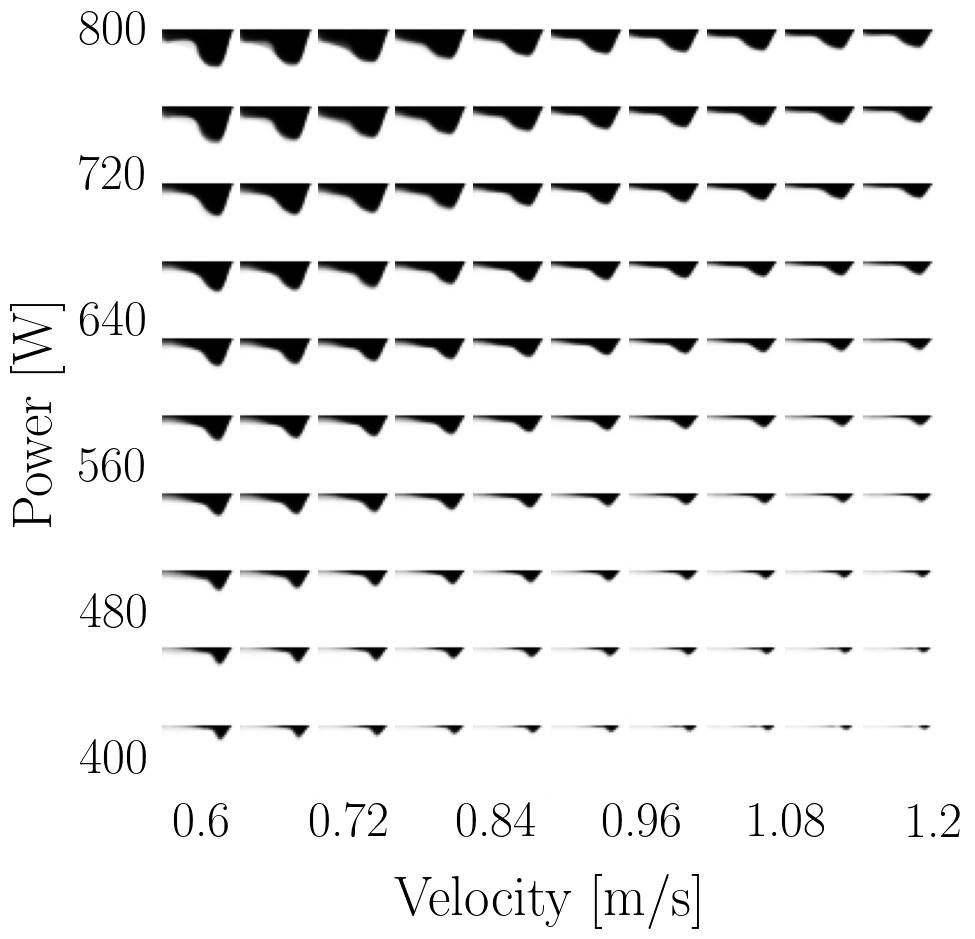

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from param2weld.predict.ensemble import load_ensemble_models, predict_ensemble
from param2weld.data.scaler import load_scaler
from sklearn.preprocessing import StandardScaler


def plot_image_grid(
    grid, xvals, yvals,
    cmap='gray',
    tick_fontsize=10,
    label_fontsize=12,
    wspace=0.05,
    hspace=0.05,
    tick_count=6,
    save_path=None,
):
    """Plot a grid of images and optionally save to disk."""
    n_rows, n_cols = grid.shape[:2]
    fig, axes = plt.subplots(n_rows, n_cols,
                             figsize=(n_cols,  n_rows),
                             squeeze=False)

    for i in range(n_rows):
        for j in range(n_cols):
            axes[i, j].imshow(grid[i, j], cmap=cmap, vmin=0, vmax=1)
            axes[i, j].axis('off')

    plt.subplots_adjust(wspace=wspace, hspace=hspace)

    ax = fig.add_subplot(111, frameon=False)
    ax.tick_params(labelcolor='black', labelsize=tick_fontsize, length=0)
    ax.set_xticks(np.linspace(0.5, n_cols - 0.5, tick_count))
    ax.set_yticks(np.linspace(0.5, n_rows - 0.5, tick_count))
    ax.set_xticklabels(np.linspace(xvals.min(), xvals.max(), tick_count).round(2))
    ax.set_yticklabels(np.linspace(yvals.min(), yvals.max(), tick_count).astype(int))
    ax.set_xlabel('Velocity [m/s]', fontsize=label_fontsize, labelpad=20)
    ax.set_ylabel('Power [W]', fontsize=label_fontsize, labelpad=10)

    # add some padding to x tick labels
    ax.yaxis.set_tick_params(pad=10)

    ax.xaxis.set_label_position('bottom')
    ax.yaxis.set_label_position('left')
    for spine in ax.spines.values():
        spine.set_visible(False)

    if save_path:
        save_path = Path(save_path)
        save_path.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path, bbox_inches='tight', dpi=300)

    plt.show()

# predict and plot for different spot sizes
resolution = 32
folds = 10
velocities = np.linspace(0.6, 1.2, 10)

spot_configs = [
    {"spot_size": 95.0, "powers": np.linspace(200, 600, 10)},
    {"spot_size": 140.0, "powers": np.linspace(400, 800, 10)},
]

for mode in ["mean", "median"]:
    model_dir = Path("models") / mode / "mae80_ssim20"
    models = load_ensemble_models(model_dir, fold_count=folds)
    scalers = [load_scaler(model_dir / f"scaler_fold_{i}.pkl") for i in range(folds)]

    # Average scaler mean_ and scale_
    mean_ = sum(s.mean_ for s in scalers) / folds
    scale_ = sum(s.scale_ for s in scalers) / folds
    scaler = StandardScaler()
    scaler.mean_, scaler.scale_ = mean_, scale_

    for cfg in spot_configs:
        spot_size = cfg["spot_size"]
        powers = cfg["powers"]
        V, P = np.meshgrid(velocities, powers[::-1])  # power flipped vertically for top-to-bottom
        input_grid = np.stack([V.ravel(), P.ravel(), np.full(V.size, spot_size)], axis=1)
        input_scaled = scaler.transform(input_grid)

        preds = predict_ensemble(models, input_scaled)
        preds = preds.reshape(10, 10, resolution, resolution)

        filename = f"figures/parameter_grids/{mode}_{int(spot_size)}um_grid.pdf"
        plot_image_grid(
            preds,
            xvals=velocities,
            yvals=powers,
            tick_fontsize=36,
            label_fontsize=40,
            wspace=0.05,
            hspace=0.05,
            save_path=filename,
        )

In [ ]:
fold_0 = """
ml_0.58_534_96
ml_0.6_400_140
ml_0.72_500_140
ml_0.72_700_140
ml_0.84_400_140
ml_0.84_500_140
ml_0.84_600_95
ml_0.96_700_140
ml_0.9_550_95
ml_0.9_600_95
"""

fold_1 = """
ml_0.66_465_96
ml_0.6_500_140
ml_0.72_200_95
ml_0.73_515_128
ml_0.84_300_95
ml_0.84_800_140
ml_0.92_605_95
ml_0.96_600_140
ml_1.08_600_140
ml_1.08_800_140
"""

fold_2 = """
ml_0.6_400_95
ml_0.6_600_95
ml_0.75_533_95
ml_0.76_474_98
ml_0.77_617_98
ml_0.84_600_140
ml_0.87_525_95
ml_0.96_600_95
ml_1.08_400_95
ml_1.08_500_140
"""

fold_3 = """
ml_0.67_608_95
ml_0.69_579_126
ml_0.6_300_95
ml_0.6_700_140
ml_0.80_533_95
ml_0.81_481_95
ml_0.97_606_95
ml_1.08_300_95
ml_1.2_500_95
ml_1.2_600_140
"""

fold_4 = """
ml_0.63_609_96
ml_0.6_500_95
ml_0.6_800_140
ml_0.72_300_95
ml_0.72_600_140
ml_0.72_600_95
ml_0.72_800_140
ml_0.89_583_95
ml_0.96_800_140
ml_1.08_400_140
"""

fold_5 = """
ml_0.68_596_96
ml_0.6_200_95
ml_0.81_550_130
ml_0.84_200_95
ml_0.94_501_95
ml_0.96_400_140
ml_1.08_700_140
ml_1.2_200_95
ml_1.2_800_140
"""

fold_6 = """
ml_0.84_500_95
ml_0.84_700_140
ml_0.88_533_95
ml_0.90_585_95
ml_0.96_300_95
ml_0.96_500_140
ml_0.96_500_95
ml_1.08_200_95
ml_1.2_700_140
"""

fold_7 = """
ml_0.77_499_95
ml_0.84_400_95
ml_0.85_550_95
ml_0.94_560_105
ml_0.95_433_125
ml_0.95_555_95
ml_0.96_400_95
ml_1.2_400_95
ml_1.2_500_140
"""

fold_8 = """
ml_0.61_412_106
ml_0.63_556_95
ml_0.72_400_95
ml_0.72_500_95
ml_0.75_436_96
ml_0.82_550_95
ml_0.88_600_95
ml_1.08_500_95
ml_1.2_400_140
"""

fold_9 = """
ml_0.6_600_140
ml_0.72_400_140
ml_0.88_567_95
ml_0.96_200_95
ml_0.98_589_95
ml_1.05_605_115
ml_1.08_600_95
ml_1.2_300_95
ml_1.2_600_95
"""

In [4]:
!ls -d ../../param2weld-project/models/kfold/32/mae80-ssim20*

ls: cannot access '../../param2weld-project/models/kfold/32/mae80-ssim20*': No such file or directory


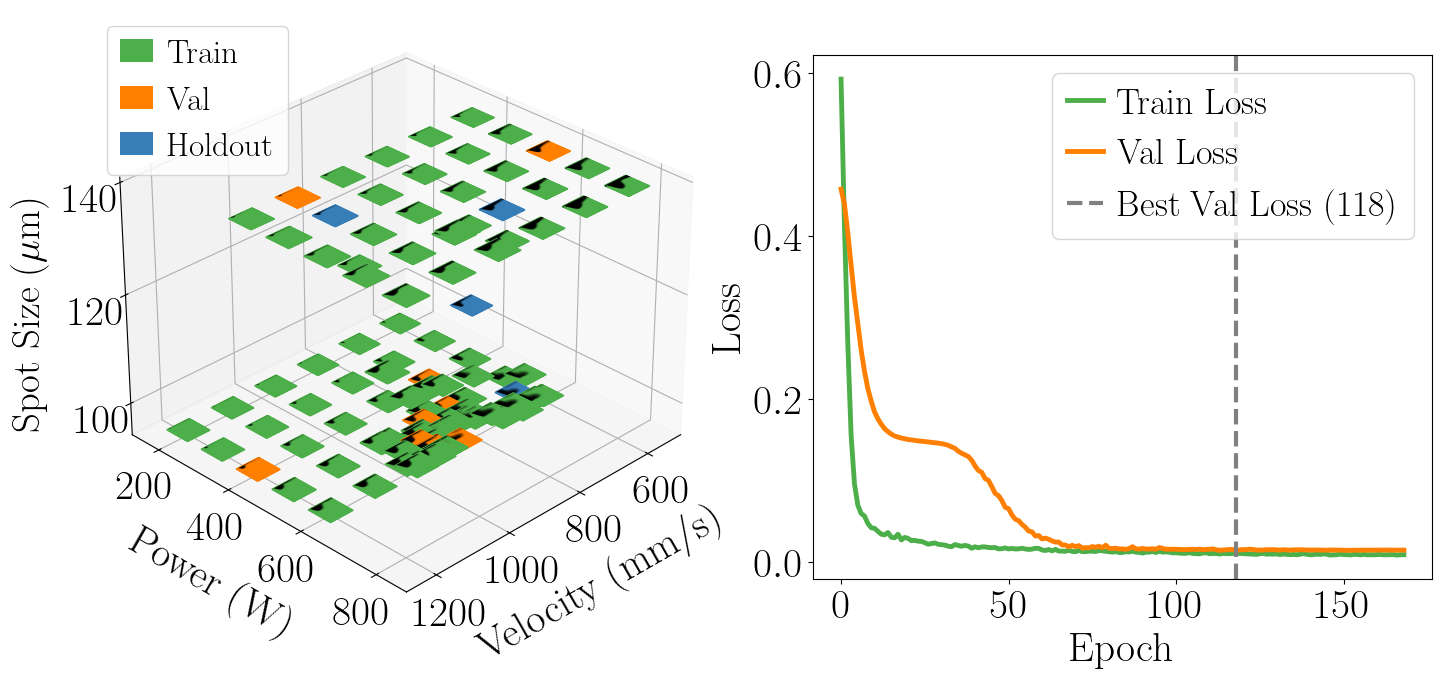

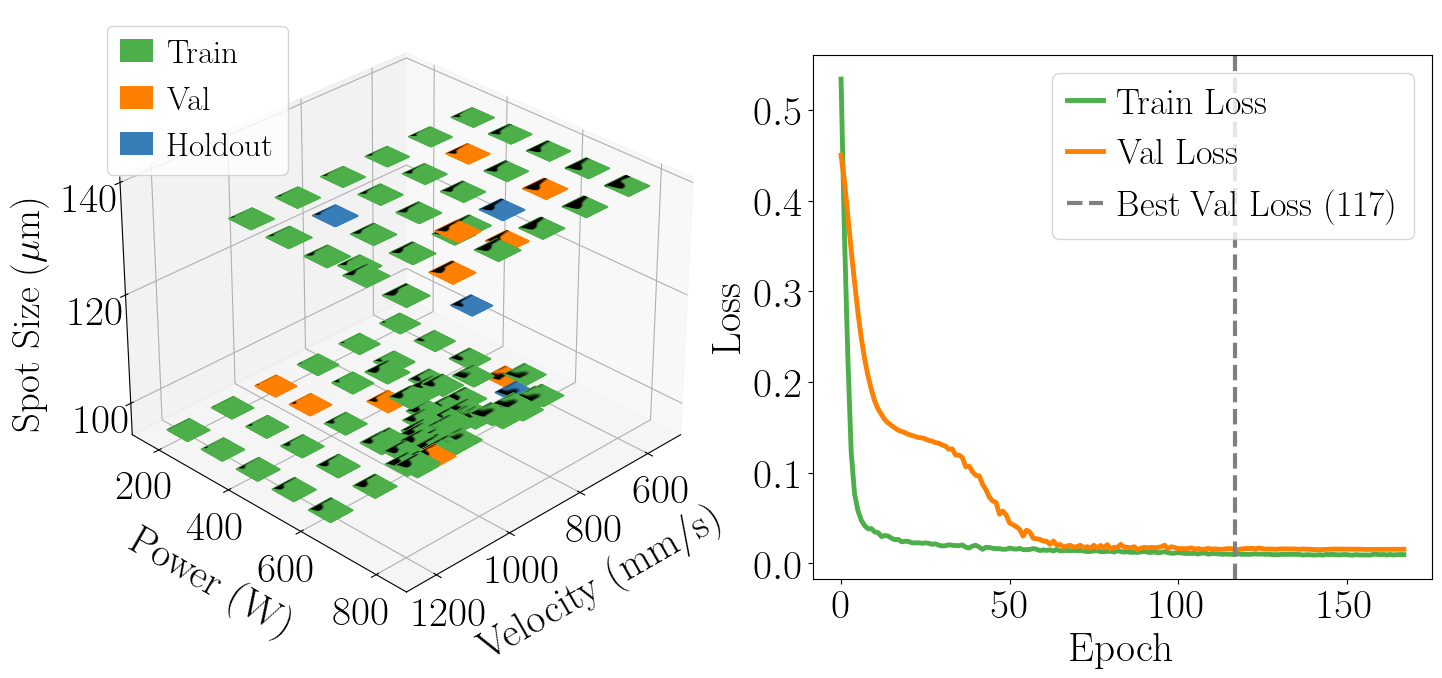

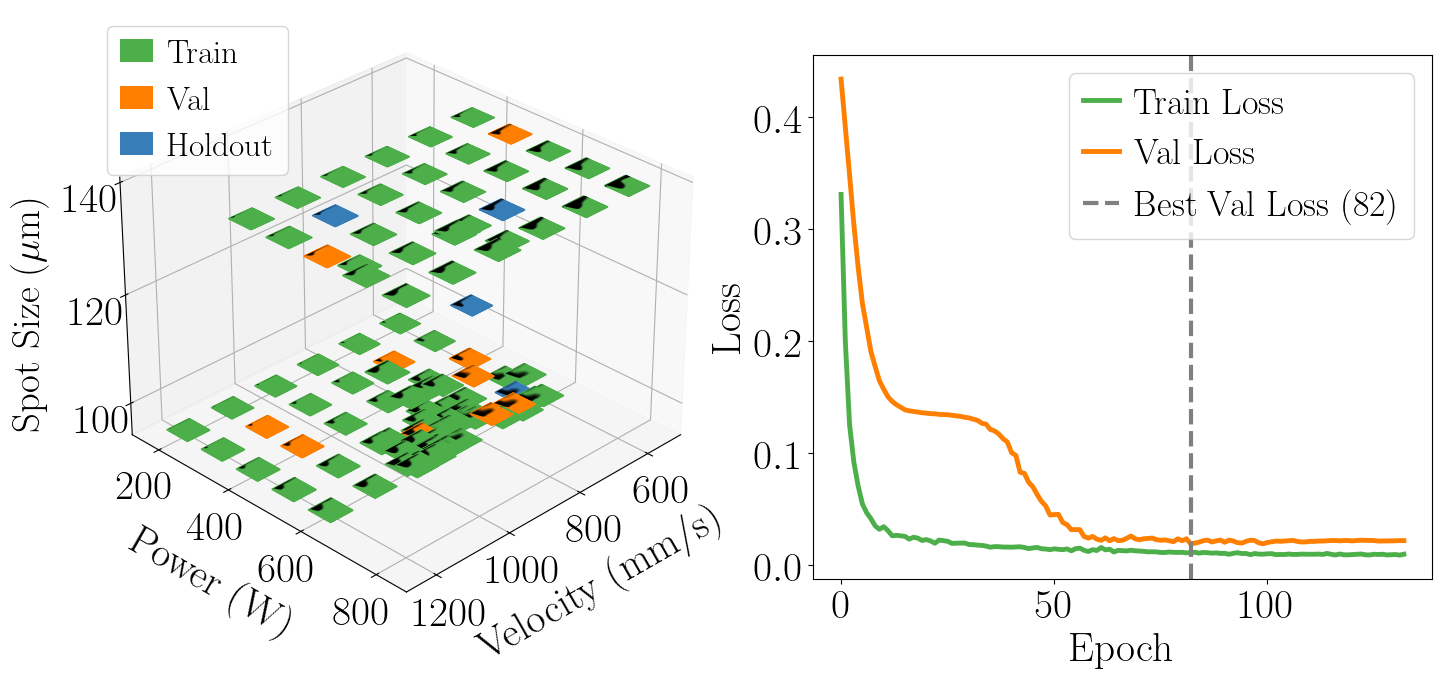

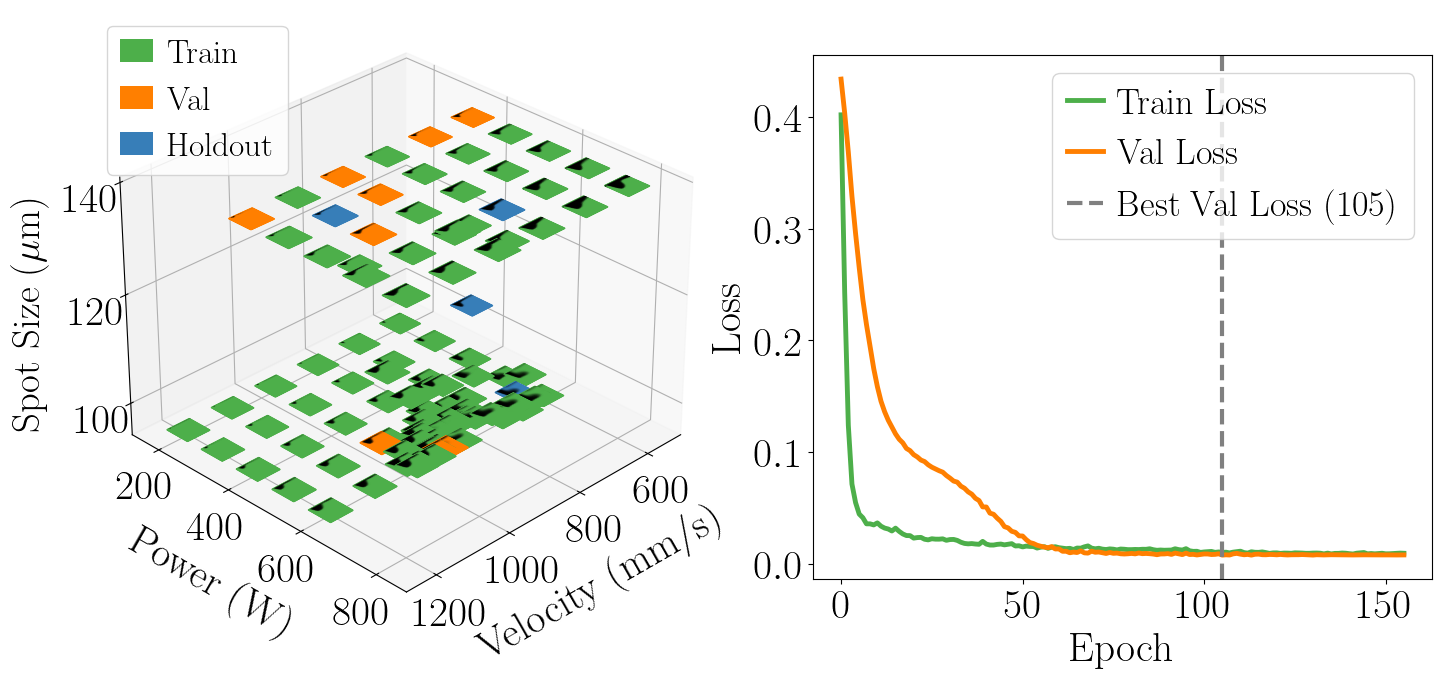

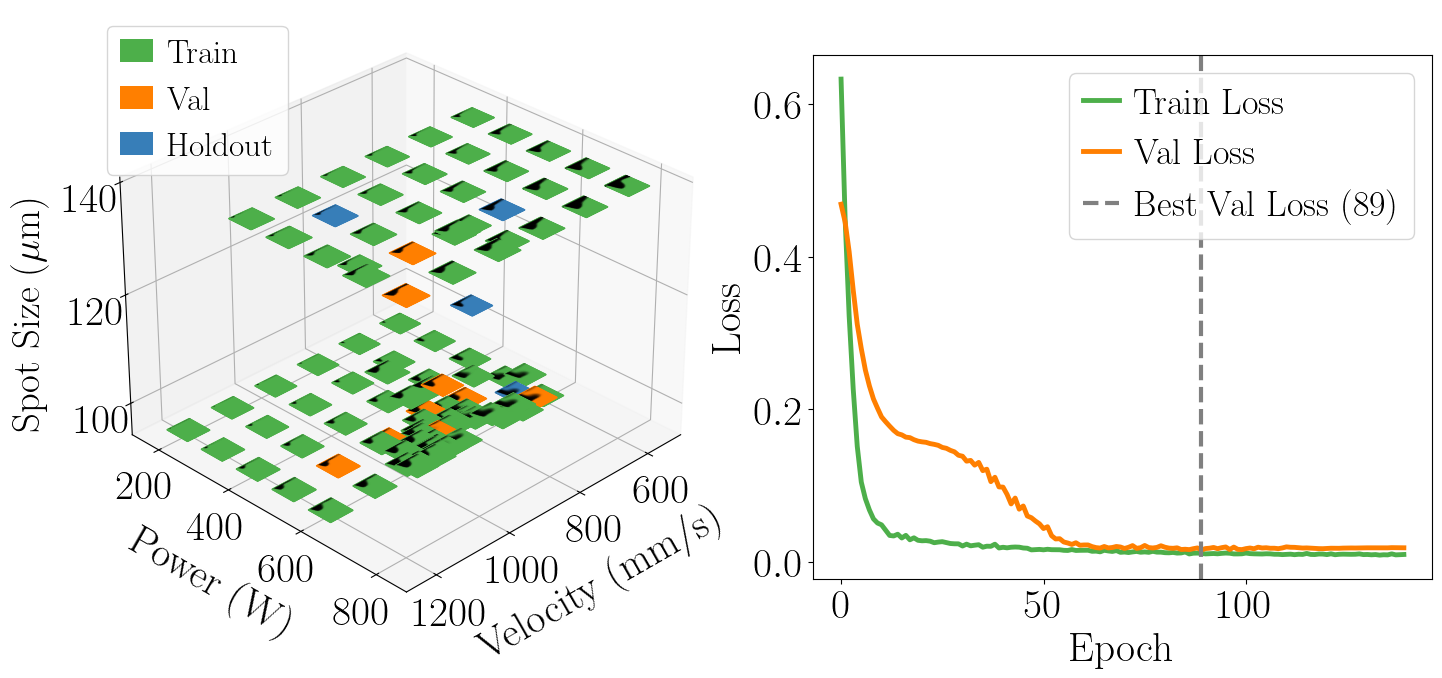

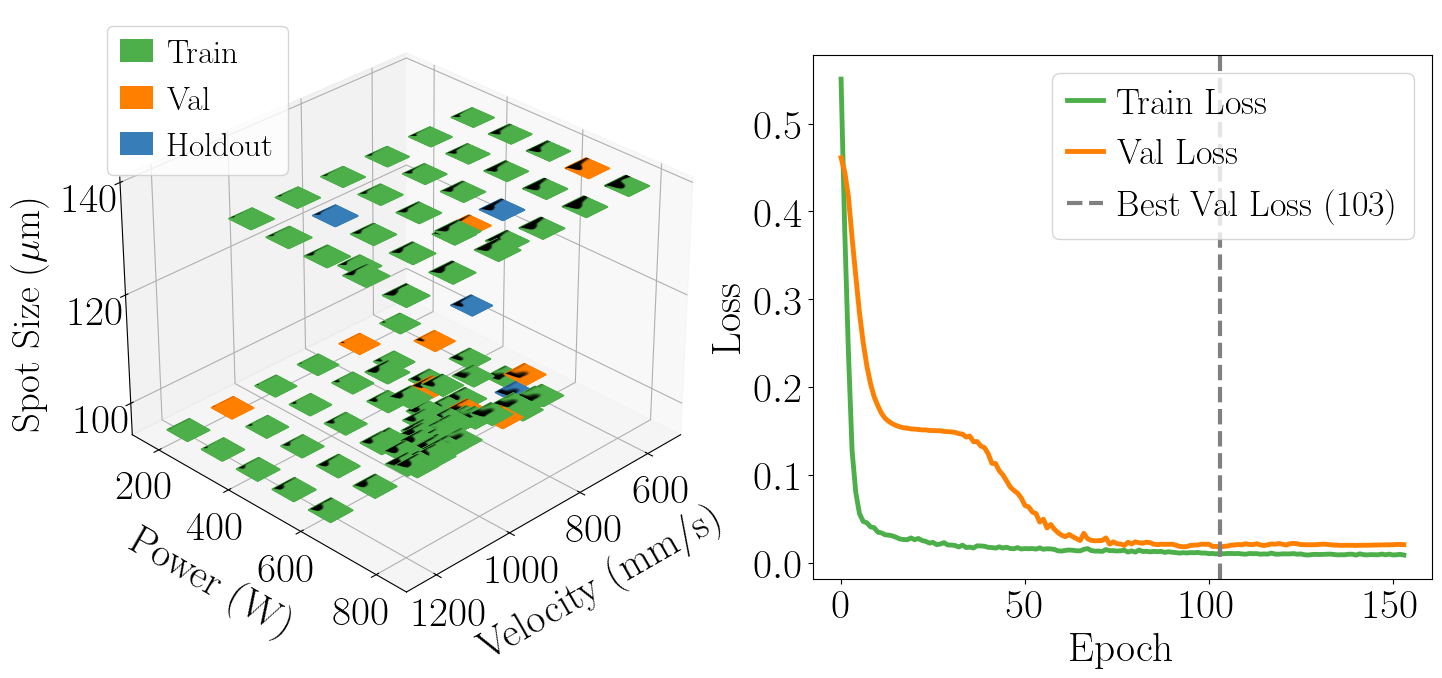

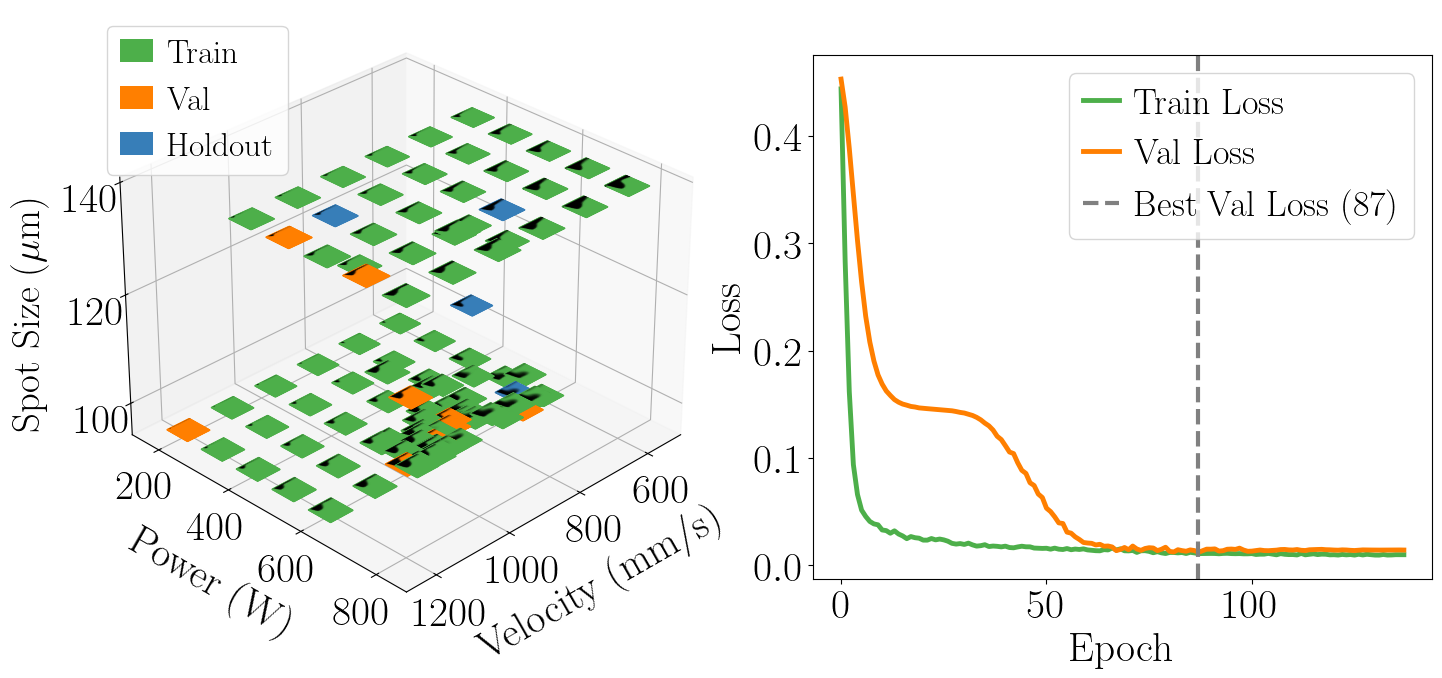

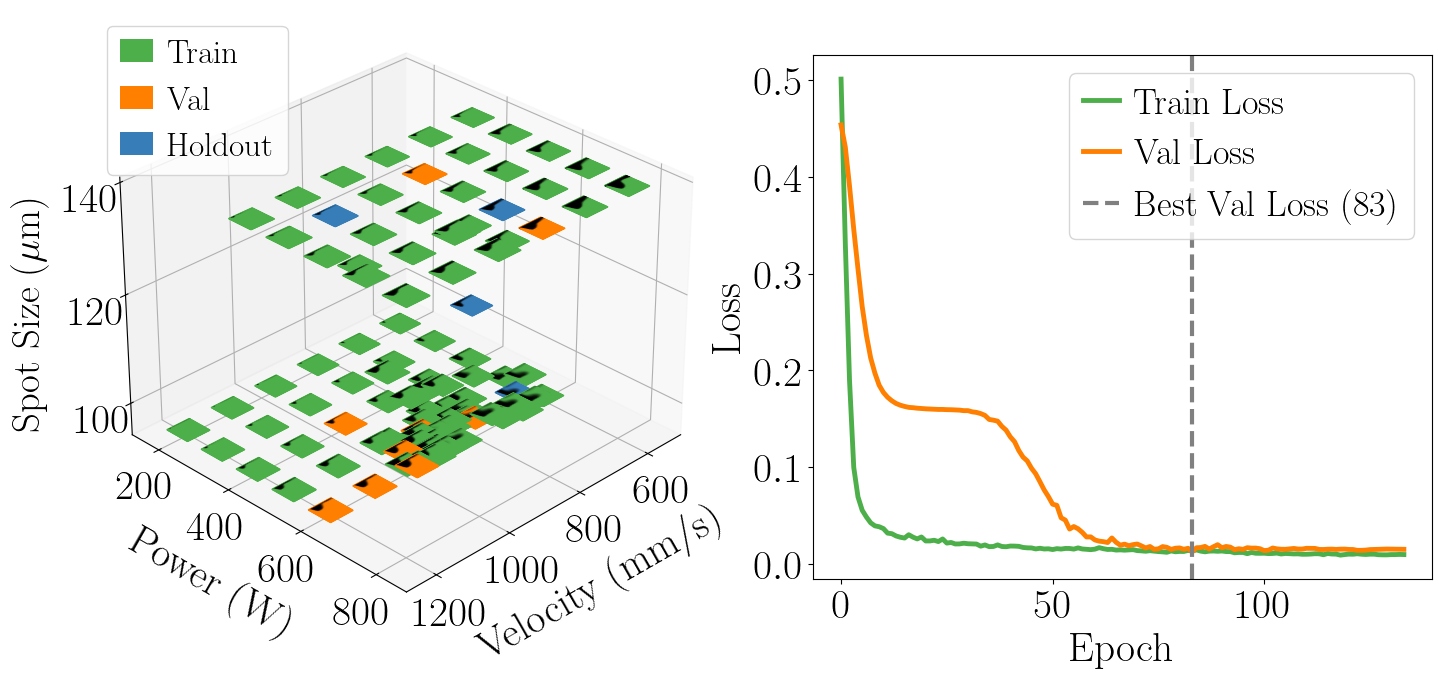

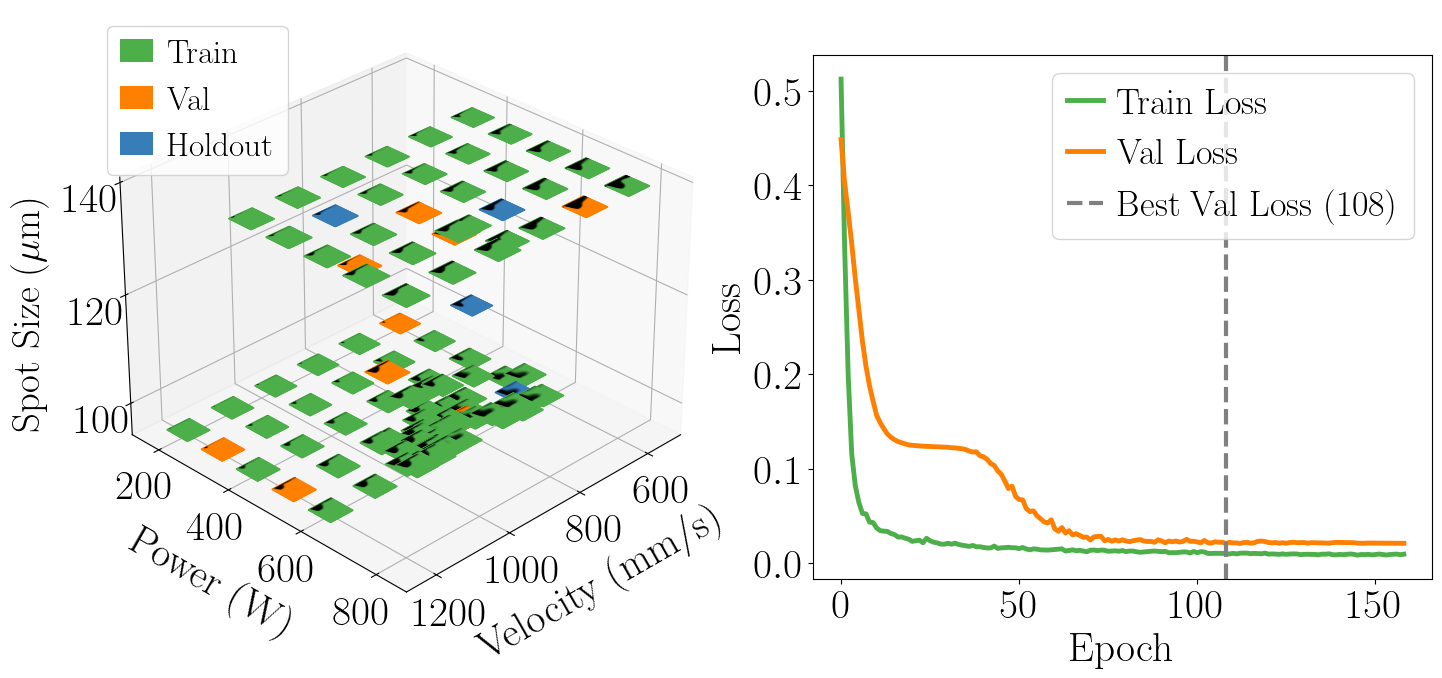

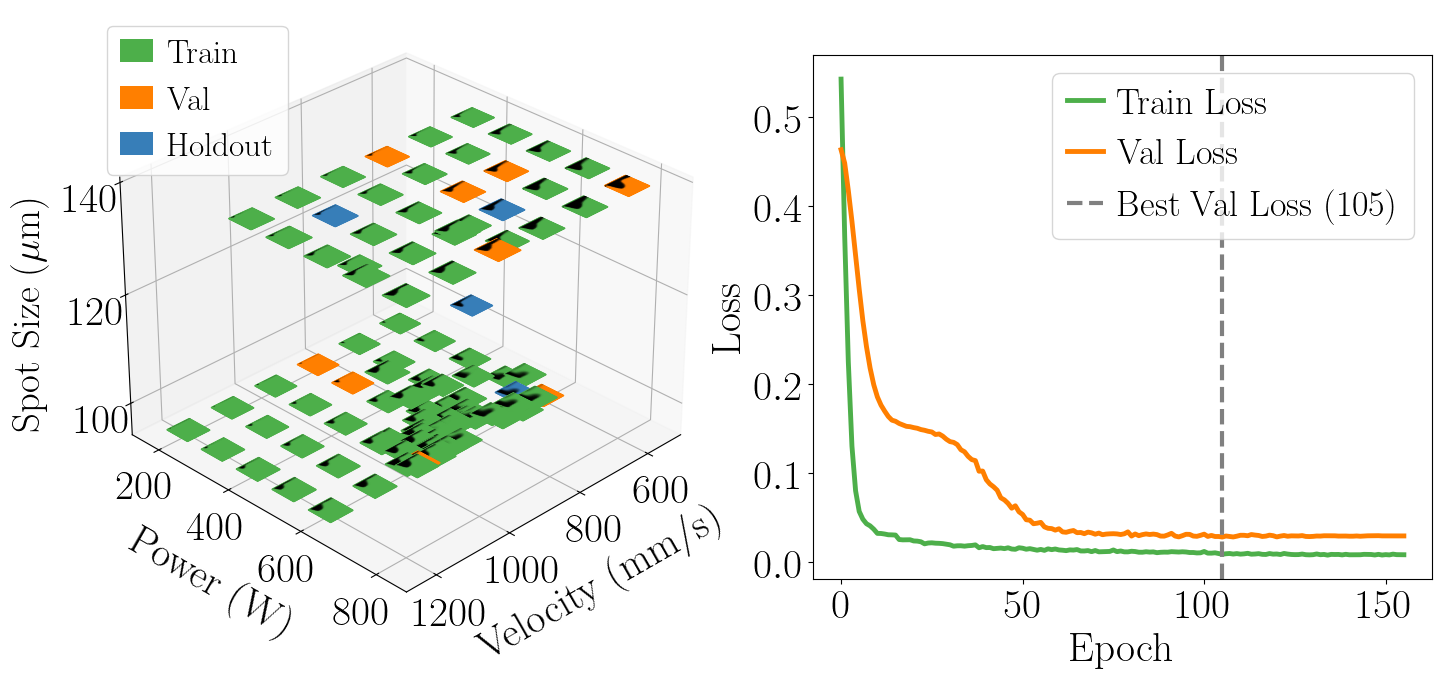

In [12]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.patches import Patch
from mpl_toolkits.mplot3d import Axes3D
from pathlib import Path
from PIL import Image

from param2weld.data.loader import load_data


data_dir = Path("./data")
holdout_dir = Path("./holdout-data")
model_dir = data_dir.parent / "models" / "mean" / "mae80_ssim20"
json_path = model_dir / "kfold_val_folders.json"
fig_save_dir = data_dir.parent / "figures" / "training-loss"
fig_save_dir.mkdir(parents=True, exist_ok=True)

resolution = 32

# Load all sim_* folders from both data and holdout-data directories
folders = [str(p) for p in data_dir.glob("sim_*") if p.is_dir()]
folders += [str(p) for p in holdout_dir.glob("sim_*") if p.is_dir()]
X, y, folder_names = load_data(folders, resolution=resolution, start_frac=0.5, end_frac=0.8, mid_mode="mean")

# Prepare a dictionary for plotting: folder name -> (velocity, power, spot size, image)
folder_data = {}
for i, fpath in enumerate(folder_names):
    name = Path(fpath).name
    v, p, s = X[i]
    img = y[i].reshape(resolution, resolution)
    folder_data[name] = (v * 1000, p, s, img)  # convert velocity to mm/s for display

# Get unique axis values
velocities = sorted(set(v for v, _, _, _ in folder_data.values()))
powers = sorted(set(p for _, p, _, _ in folder_data.values()), reverse=True)
spot_sizes = sorted(set(s for _, _, s, _ in folder_data.values()))

# Load fold assignments
with open(json_path, "r") as f:
    fold_json = json.load(f)

# Collect names of holdout folders
holdout_folders = {f.name for f in (holdout_dir).glob("sim_*") if f.is_dir()}

# Loop over all folds
for fid in range(len(fold_json)):
    val_set = {Path(p).name for p in fold_json[str(fid)]["val"]}
    train_set = {Path(p).name for p in fold_json[str(fid)]["train"]}

    data_grid = {}
    for fname, (v, p, s, img) in folder_data.items():
        data_grid[(v, p, s)] = (img, fname)

    fig = plt.figure(figsize=(18, 8))
    gs = gridspec.GridSpec(1, 2, width_ratios=[7, 6], wspace=0.08)
    ax1 = fig.add_subplot(gs[0], projection='3d')
    ax2 = fig.add_subplot(gs[1])

    # Reposition ax2 to center it vertically
    pos1 = ax1.get_position()
    pos2 = ax2.get_position()
    shrink_ratio = 0.85
    new_height = pos1.height * shrink_ratio
    center_y = pos1.y0 + pos1.height / 2
    new_y0 = center_y - new_height / 2
    new_pos2 = [pos2.x0, new_y0, pos2.width, new_height]
    ax2.set_position(new_pos2)

    fig.text(0.11, 0.5, "Spot Size ($\\mu$m)", va='center', rotation=90, fontsize=28)
    ax1.set_xlabel("Velocity (mm/s)", labelpad=20)
    ax1.set_ylabel("Power (W)", labelpad=20)

    # Create legend entries for the color categories
    legend_elements = [
        Patch(facecolor=mygreen, edgecolor='none', label='Train'),
        Patch(facecolor=myorange, edgecolor='none', label='Val'),
        Patch(facecolor=myblue, edgecolor='none', label='Holdout'),
    ]
    ax1.legend(handles=legend_elements, loc='upper left', frameon=True, fontsize=24)

    # Plot each image at its parameter location in 3D space
    image_scale = 30
    for s in spot_sizes:
        for p in powers:
            for v in velocities:
                key = (v, p, s)
                if key not in data_grid:
                    continue
                img, folder = data_grid[key]

                # Determine the color category
                if folder in val_set:
                    color = myorange
                elif folder in train_set:
                    color = mygreen
                elif folder in holdout_folders:
                    color = myblue
                else:
                    continue

                # Normalize and tint image according to color
                img = (img - img.min()) / (img.max() - img.min() + 1e-5)
                base_rgb = tuple(int(color[i:i+2], 16)/255. for i in (1, 3, 5))
                R, G, B = img * base_rgb[0], img * base_rgb[1], img * base_rgb[2]
                A = np.ones_like(img)
                img_rgba = np.stack([R, G, B, A], axis=-1)

                # Map image to surface in 3D space
                H, W = img.shape
                x_range = np.linspace(v - image_scale, v + image_scale, W)
                y_range = np.linspace(p - image_scale, p + image_scale, H)
                X, Y = np.meshgrid(x_range, y_range)
                Z = np.full_like(X, s)

                ax1.plot_surface(X, Y, Z, rstride=1, cstride=1, facecolors=img_rgba, shade=False)

    ax1.view_init(elev=30, azim=45)

    # Plot training and validation loss curves
    hist_path = model_dir / f"history_fold_{fid}.npy"
    if hist_path.exists():
        history = np.load(hist_path, allow_pickle=True).item()
        ax2.plot(history["loss"], label="Train Loss", color=mygreen, linewidth=3.5)
        ax2.plot(history["val_loss"], label="Val Loss", color=myorange, linewidth=3.5)
        best_epoch = int(np.argmin(history["val_loss"]))
        ax2.axvline(best_epoch, linestyle="--", color="gray", label=f"Best Val Loss ({best_epoch})", linewidth=3)
        ax2.set_xlabel("Epoch")
        ax2.set_ylabel("Loss")
        ax2.legend(fontsize=26, loc='upper right')
        # ax2.grid(True)

    # Save the figure
    # fig.savefig(fig_save_dir / f"fold_{fid}.png", bbox_inches='tight')
    fig.savefig(fig_save_dir / f"fold_{fid}.pdf", bbox_inches='tight')
    plt.show()


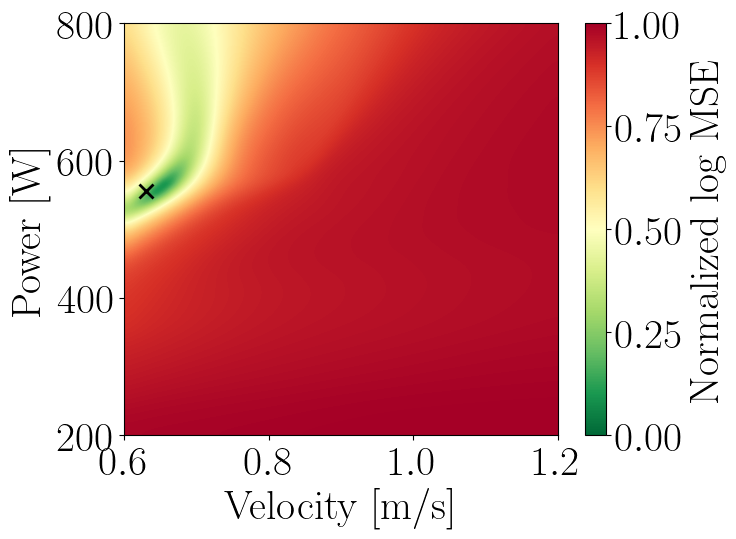

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from skimage.metrics import mean_squared_error
from PIL import Image
import param2weld.utils.plot_config  # latex config

from param2weld.data.loader import load_data
from param2weld.data.scaler import load_scaler
from param2weld.predict.ensemble import load_ensemble_models, predict_ensemble

# Settings
resolution = 32
matrix_size = 50
mid_mode = "median"  # "mean" or "median"

# Target experiment
# target_folder = Path("holdout-data/sim_0.84_700_140")
# target_folder = Path("holdout-data/sim_1.08_500_140/")
target_folder = Path("holdout-data/sim_0.63_556_95/")

_, v_str, p_str, ss_str, *_ = target_folder.name.split("_")
target_velocity = float(v_str)
target_power = float(p_str)
target_spot = float(ss_str)

model_dir = Path(f"models/{mid_mode}/mae80_ssim20")

# Output folders
heatmap_dir = Path("figures/heatmaps")
heatmap_dir.mkdir(parents=True, exist_ok=True)

# File paths
heatmap_path = heatmap_dir / f"similarity_heatmap_{mid_mode}_{target_velocity}_{int(target_power)}_{int(target_spot)}.pdf"
target_img_path = heatmap_dir / f"target_{mid_mode}_{target_velocity}_{int(target_power)}_{int(target_spot)}.png"

# Load target image using param2weld loader
_, y_target, _ = load_data(
    folders=[target_folder],
    resolution=resolution,
    mid_mode=mid_mode,
    start_frac=0.5,
    end_frac=0.8
)

if y_target.size == 0:
    raise ValueError("Target image could not be loaded.")

target_img = y_target[0].reshape(resolution, resolution)

# Save target image using matplotlib
fig, ax = plt.subplots(figsize=(1.5, 1.5), dpi=100)
ax.imshow(target_img, cmap="gray", vmin=0, vmax=1)
ax.axis("off")
plt.tight_layout(pad=0)
fig.savefig(target_img_path, bbox_inches="tight", pad_inches=0)
plt.close(fig)

# Load ensemble models and scalers
scalers = [load_scaler(model_dir / f"scaler_fold_{i}.pkl") for i in range(10)]
models = load_ensemble_models(model_dir)

def average_scaler_transform(X, scalers):
    return np.mean([s.transform(X) for s in scalers], axis=0)

# Build velocity × power grid
velocities = np.linspace(0.6, 1.2, matrix_size)
powers = np.linspace(200, 800, matrix_size)
V, P = np.meshgrid(velocities, powers)
input_grid = np.stack([V.ravel(), P.ravel(), np.full(V.size, target_spot)], axis=1)
input_scaled = average_scaler_transform(input_grid, scalers)

# Predict with ensemble
predictions = predict_ensemble(models, input_scaled).squeeze(-1)

# Compute similarity to target image
similarity_grid = np.array([
    mean_squared_error(pred, target_img) for pred in predictions
]).reshape(matrix_size, matrix_size)

# Save and show heatmap
def plot_similarity_heatmap(sim_grid, velocities, powers, target_velocity, target_power, save_path=None):
    log_sim_grid = np.log(sim_grid + 1e-6)
    log_sim_grid = (log_sim_grid - log_sim_grid.min()) / (log_sim_grid.max() - log_sim_grid.min())

    fig, ax = plt.subplots(figsize=(7.25, 5.5))
    extent = [velocities.min(), velocities.max(), powers.min(), powers.max()]
    im = ax.imshow(log_sim_grid, extent=extent, origin='lower', aspect='auto',
                   interpolation='bicubic', cmap='RdYlGn_r')
    ax.plot(target_velocity, target_power, marker='x', color='black', markersize=10, markeredgewidth=2)
    ax.set_xlabel("Velocity [m/s]")
    ax.set_ylabel("Power [W]")
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label("Normalized log MSE")
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.tight_layout()
    plt.show()

plot_similarity_heatmap(similarity_grid, velocities, powers, target_velocity, target_power, save_path=heatmap_path)
